<a href="https://colab.research.google.com/github/ranaehelal/FSDD-0-1-NB-LR-Bagging/blob/main/fsdd_naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Dataset Preparation

## imports

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

In [124]:
import os

files = [f for f in os.listdir() if f.endswith('.wav')]

# Number of samples
num_samples = len(files)

class_counts = {"0": 0, "1": 0}
for f in files:
    if f.startswith("0"):
        class_counts["0"] += 1
    elif f.startswith("1"):
        class_counts["1"] += 1

print(f"Total samples: {num_samples}")

print(f"Class distribution: {class_counts}")



Total samples: 600
Class distribution: {'0': 300, '1': 300}


## Reading Audio Files


In [125]:
audio_files = glob('../*/*.wav')
ipd.Audio(audio_files[1])

## print audio y , sample rate sr

In [126]:
y, sr = librosa.load(audio_files[1])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-4.1368671e-04 -3.9557490e-04 -2.4044453e-04 -2.4746329e-04
 -3.9667412e-04 -5.8402761e-04 -6.6681555e-04 -5.5460067e-04
 -3.0601188e-04 -7.4057010e-05]
shape y: (11974,)
sr: 22050


#2. Preprocessing and Feature Extraction

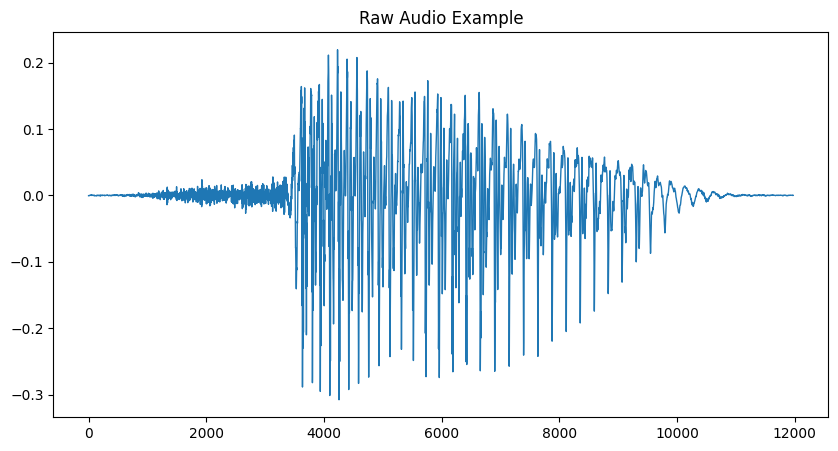

In [127]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example')
plt.show()

##Noise reduction

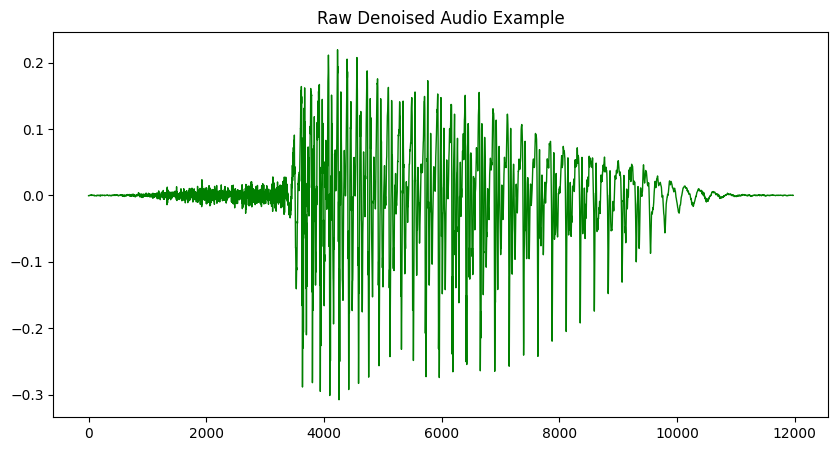

In [128]:
y_denoised = librosa.effects.preemphasis(y)
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Denoised Audio Example'
                  ,color='green')
plt.show()

##Silence removal

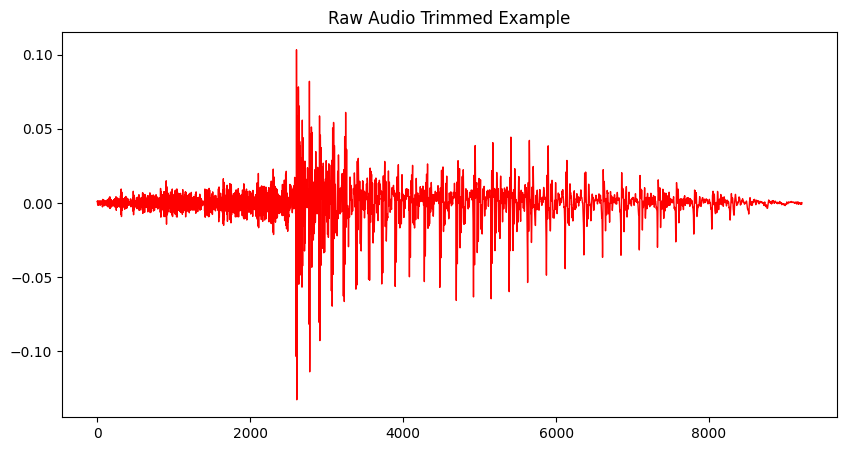

In [129]:
y_trimmed, _ = librosa.effects.trim(y_denoised, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color='red')
plt.show()

##Normalization

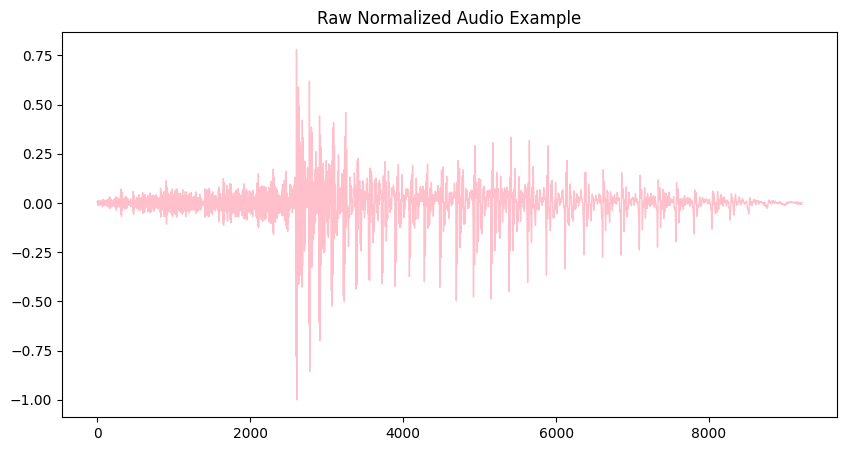

In [130]:
y_normalized = librosa.util.normalize(y_trimmed)
pd.Series(y_normalized).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Normalized Audio Example',
                 color='pink')
plt.show()

## data preprocessing

In [131]:
def preprocess_audio(audio_file):

    y, sr = librosa.load(audio_file, sr=None)

    y_denoised = librosa.effects.preemphasis(y)

    y_trimmed, _ = librosa.effects.trim(y_denoised, top_db=30)

    y_normalized = librosa.util.normalize(y_trimmed)

    return y_normalized, sr

In [132]:
processed_audios = []

for audio_file in audio_files:
    y_processed, sr = preprocess_audio(audio_file)
    processed_audios.append((y_processed, sr))


##Feature Extraction

* MFCCs capture important speech patterns like how we hear.
* Spectral features (Centroid & Rolloff) show pitch and sharpness.
* ZCR measures how fast the sound changes (noisiness).



In [133]:
features = []

for y_processed, sr in processed_audios:
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y_processed, sr=sr, n_mfcc=20)

    # Extract Spectral Features
    spectral_centroid = librosa.feature.spectral_centroid(y=y_processed, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y_processed, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y_processed)

    # Extract Delta MFCCs

    # Extract Chroma Features
    chroma = librosa.feature.chroma_stft(y=y_processed, sr=sr)

    # Extract Tonnetz
    tonnetz = librosa.feature.tonnetz(y=y_processed)

    # Extract RMS Energy
    rms = librosa.feature.rms(y=y_processed)

    feature_vector = [
      np.mean(mfccs), np.std(mfccs),
      np.mean(spectral_centroid), np.std(spectral_centroid),
      np.mean(spectral_rolloff), np.std(spectral_rolloff),
      np.mean(zero_crossing_rate), np.std(zero_crossing_rate),
      np.mean(chroma), np.std(chroma),
      np.mean(tonnetz), np.std(tonnetz),
      np.mean(rms), np.std(rms)
    ]

    # Append the feature vector to the features list
    features.append(feature_vector)


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=634
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=317
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=159
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=80
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=543
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=272
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: U

In [134]:
df_features = pd.DataFrame(features, columns=[
    'Mean_MFCCs', 'Std_MFCCs',
    'Mean_Spectral_Centroid', 'Std_Spectral_Centroid',
    'Mean_Spectral_Rolloff', 'Std_Spectral_Rolloff',
    'Mean_Zero_Crossing_Rate', 'Std_Zero_Crossing_Rate',
    'Mean_Chroma', 'Std_Chroma',
    'Mean_Tonnetz', 'Std_Tonnetz',
    'Mean_RMS_Energy', 'Std_RMS_Energy'
])


In [135]:
labels=[]
for f in files:
    if f.startswith("0"):
        labels.append('0')
    elif f.startswith("1"):
        labels.append('1')

In [136]:
df_features['Label'] = labels


In [137]:
print(df_features.head())


   Mean_MFCCs  Std_MFCCs  Mean_Spectral_Centroid  Std_Spectral_Centroid  \
0  -18.030827  28.845455             1332.001778             365.071452   
1  -20.133842  43.570972             1656.299259             570.349421   
2  -19.376446  35.376221             1420.539628             231.794541   
3  -16.914909  28.905876             1599.613959             258.468662   
4  -19.673592  25.855944             1672.143826             293.548705   

   Mean_Spectral_Rolloff  Std_Spectral_Rolloff  Mean_Zero_Crossing_Rate  \
0            2525.000000            649.855378                 0.158984   
1            2486.111111            622.937981                 0.324653   
2            2653.906250            326.807250                 0.238184   
3            2841.517857            334.688404                 0.262556   
4            3138.020833            287.524649                 0.273763   

   Std_Zero_Crossing_Rate  Mean_Chroma  Std_Chroma  Mean_Tonnetz  Std_Tonnetz  \
0                

In [138]:
df_features.to_csv('zero_one_audio_features.csv', index=False)


In [139]:
from sklearn.model_selection import train_test_split
X = df_features.drop('Label', axis=1).values.astype(float)
y = df_features['Label'].astype(int).values

from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)




#3. Implement Naïve Bayes Classifier from Scratch

 *photos*

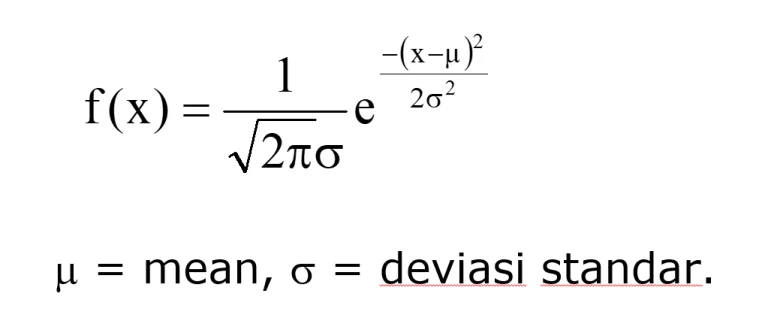

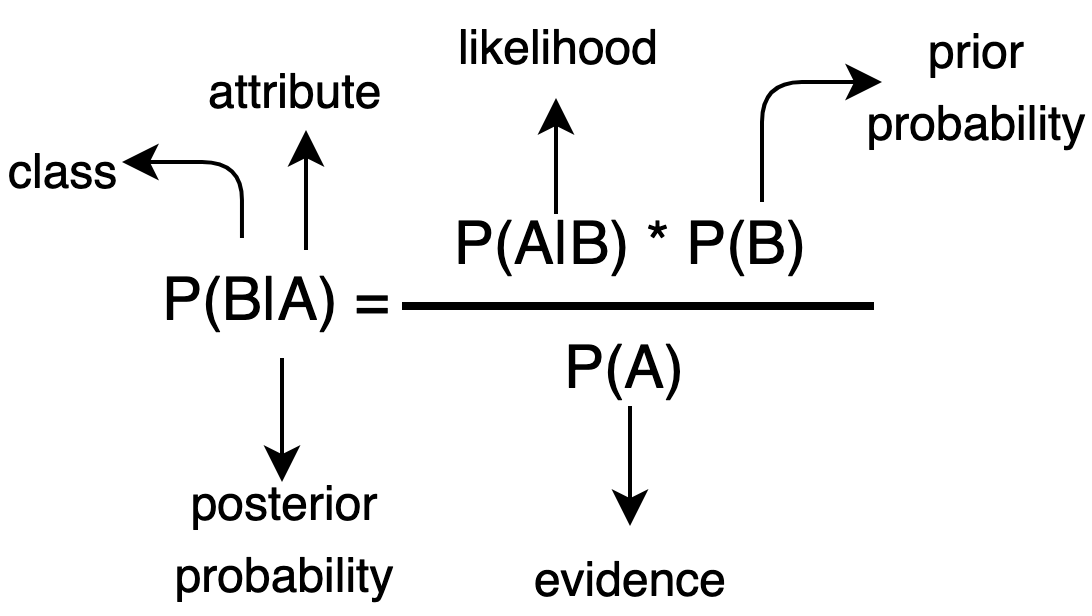

##Naïve Bayes from Scratch class

In [140]:
class GaussianNaiveBayes :
  def fit (self,X,y):
    #calculate mean and var for each feature
    self.classes=np.unique(y) #0, 1
    self.means={}
    self.variances={}
    self.priors={}

    for class1 in self.classes:
        X_class=X[y==class1]
        self.means[class1]=X_class.mean(axis=0) #go col by col
        self.variances[class1]=X_class.var(axis=0)
        self.priors[class1]=X_class.shape[0]/X.shape[0] # how many samples in class / how mant in total

  def gaussian (self,x,mean,var):
    eps = 1e-9  #to avoid dev by 0 if all values 00
    coef = 1.0 / np.sqrt(2.0 * np.pi * var + eps)
    exponent = np.exp(- ((x - mean) ** 2) / (2 * var + eps))
    return coef * exponent

  def predict(self,X):
    predictions=[]

    for x in X :
      # loop for each data
      posteriors={}
      for class1 in self.classes :
        prior=np.log(self.priors[class1])
        likelihood=np.sum(np.log(self.gaussian(x, self.means[class1], self.variances[class1])))
        #calculate likelihood for each feature in the class
        #then take the log for each and sum all
        posteriors[class1]=prior+likelihood
      predictions.append(max(posteriors,key=posteriors.get))


    return predictions

  # Function to evaluate model metrics: accuracy, precision, recall, F1-score
  def evaluate(self, y_true, y_pred):
        accuracy = np.mean(y_true == y_pred)  # Accuracy = correct predictions / total predictions
        precision = self.precision(y_true, y_pred)
        recall = self.recall(y_true, y_pred)
        f1_score = self.f1_score(precision, recall)
        return accuracy, precision, recall, f1_score

  def precision(self, y_true, y_pred):
        # Precision = TP / (TP + FP)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        return TP / (TP + FP) if TP + FP > 0 else 0

  def recall(self, y_true, y_pred):
        # Recall = TP / (TP + FN)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        return TP / (TP + FN) if TP + FN > 0 else 0

  def f1_score(self, precision, recall):
        # F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
        return 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0






In [142]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))


[[55  6]
 [14 45]]


In [143]:
print("True values:", y_test)
y_pred = np.array(y_pred).astype(int)
print("Predicted values:", y_pred)



True values: [0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1
 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1
 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 0
 0 1 1 1 0 0 1 1 1]
Predicted values: [0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1
 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0
 0 1 1 1 0 0 0 1 1]


In [154]:
model = GaussianNaiveBayes()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = np.array(y_pred).astype(int)

accuracy, precision, recall, f1_score = model.evaluate(y_test, y_pred)

print("Naïve Bayes from Scratch - Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Naïve Bayes from Scratch - Performance Metrics:
Accuracy: 0.8333
Precision: 0.8824
Recall: 0.7627
F1-Score: 0.8182


## Build-in Naïve Bayes

In [144]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred_sklearn = clf.predict(X_test)

print(classification_report(y_test, y_pred_sklearn))


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        61
           1       0.88      0.76      0.82        59

    accuracy                           0.83       120
   macro avg       0.84      0.83      0.83       120
weighted avg       0.84      0.83      0.83       120



## Logistic Regression (Individual Model)


In [155]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr_model = LogisticRegression(max_iter=1000)

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)

precision_lr = precision_score(y_test, y_pred_lr)

recall_lr = recall_score(y_test, y_pred_lr)

f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression - Performance Metrics:")

print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
print(f"Logistic Regression Precision: {precision_lr:.4f}")
print(f"Logistic Regression Recall: {recall_lr:.4f}")
print(f"Logistic Regression F1-Score: {f1_lr:.4f}")


Logistic Regression - Performance Metrics:
Logistic Regression Accuracy: 0.8417
Logistic Regression Precision: 0.9000
Logistic Regression Recall: 0.7627
Logistic Regression F1-Score: 0.8257


#4. Apply Bagging with Naïve Bayes and Logistic Regression

## Bagging Class

In [156]:
from sklearn.utils import resample
import numpy as np

class Bagging:
    def __init__(self, base_model, n_estimators=10):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.models = []

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            X_resampled, y_resampled = resample(X, y)
            model = self.base_model()
            model.fit(X_resampled, y_resampled)
            self.models.append(model)

    def predict(self, X):
        predictions = np.zeros((self.n_estimators, X.shape[0]))
        for i, model in enumerate(self.models):
            predictions[i, :] = model.predict(X)
        final_predictions = []
        for i in range(X.shape[0]):
            final_predictions.append(np.bincount(predictions[:, i].astype(int)).argmax())
        return np.array(final_predictions)

    def evaluate(self, y_true, y_pred):
        accuracy = np.mean(y_true == y_pred)
        precision = self.precision(y_true, y_pred)
        recall = self.recall(y_true, y_pred)
        f1_score = self.f1_score(precision, recall)
        return accuracy, precision, recall, f1_score

    def precision(self, y_true, y_pred):
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        return TP / (TP + FP) if TP + FP > 0 else 0

    def recall(self, y_true, y_pred):
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        return TP / (TP + FN) if TP + FN > 0 else 0

    def f1_score(self, precision, recall):
        return 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0




## Example Usage for Naïve Bayes

In [157]:
bagging_nb = Bagging(base_model=GaussianNaiveBayes, n_estimators=10)
bagging_nb.fit(X_train, y_train)
y_pred_bagging = bagging_nb.predict(X_test)

accuracy, precision, recall, f1_score = bagging_nb.evaluate(y_test, y_pred_bagging)

print("Bagging Naïve Bayes Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

Bagging Naïve Bayes Performance Metrics:
Accuracy: 0.8333
Precision: 0.8824
Recall: 0.7627
F1-Score: 0.8182


## Example Usage for Logistic Regression


In [158]:
from sklearn.linear_model import LogisticRegression

bagging_lr = Bagging(base_model=LogisticRegression, n_estimators=10)
bagging_lr.fit(X_train, y_train)
y_pred_bagging_lr = bagging_lr.predict(X_test)

accuracy, precision, recall, f1_score = bagging_lr.evaluate(y_test, y_pred_bagging_lr)

print("Bagging Logistic Regression Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Bagging Logistic Regression Performance Metrics:
Accuracy: 0.8333
Precision: 0.8980
Recall: 0.7458
F1-Score: 0.8148
